# 3D Latent Diffusion Model
In this tutorial, we will walk through the process of using the MONAI Generative Models package to generate synthetic data using Latent Diffusion Models (LDM)  [1, 2]. Specifically, we will focus on training an LDM to create synthetic brain images from the Brats dataset.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162

### Set up imports

In [16]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()


MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home1/<username>/.conda/envs/working_monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.2.2
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [17]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [18]:
from dataloader import Train ,Eval 
import random
import pandas as pd

### Visualise examples from the training set

In [48]:
config = {
    'batch_size': 4,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False





# %% [markdown]
# # Load the data

# %%
imgpath = {}
# '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv'
#'/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/IXI_train_fold0.csv',
#csvpath_trains = ['/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv', '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv']
csvpath_trains=['./Data/splits/combined_4datasets.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_test = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)
# %%


var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = ''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)


#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=1,shuffle=False,num_workers=8)


device = torch.device("cuda")



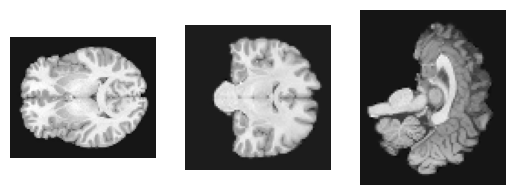

In [49]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
images = check_data['vol']['data'].to(device)
# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (check_data['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
peak_expanded = peak_expanded.to(device)

# Perform the division
images = (images / peak_expanded)

idx = 0

img = images[idx, 0].cpu()
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

## Autoencoder KL

### Define Autoencoder KL network

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images.


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [22]:
autoencoder = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(32, 64, 64),
    latent_channels=3,
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
autoencoder.to(device)


discriminator = PatchDiscriminator(spatial_dims=3, num_layers_d=3, num_channels=32, in_channels=1, out_channels=1)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fal

In [23]:

import torch.nn as nn
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    autoencoder= nn.DataParallel(autoencoder)

Using 2 GPUs!


### Train model

In [24]:
model_filename = "/scratch1/akrami/models/3Ddiffusion/latent/model_KL_epoch449.pt"
autoencoder.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise tahat is added across the diffusion's model Markov chain.

In [38]:

unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    num_channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_head_channels=(0, 64, 64),
)
unet.to(device)

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     unet= nn.DataParallel(unet)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0015, beta_end=0.0205)

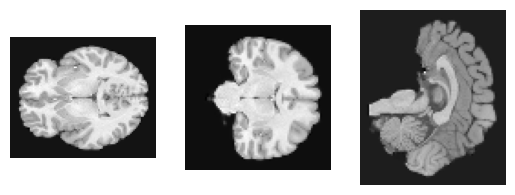

In [39]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
images = check_data['vol']['data'].to(device)
# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (check_data['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
peak_expanded = peak_expanded.to(device)

# Perform the division
images = (images / peak_expanded)

idx = 0

img = images[idx, 0].cpu()
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [40]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoder.module.encode_stage_2_inputs(images.to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9910687208175659


We define the inferer using the scale factor:

In [41]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [42]:
optimizer_diff = torch.optim.Adam(params=unet.parameters(), lr=1e-4)

### Train diffusion model

In [43]:
model_filename = "/scratch1/akrami/models/3Ddiffusion/latent/latent_KL_epoch975.pt"
unet.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. In the last step, we decode the latent representation and plot the sampled image.

100%|██████████| 1000/1000 [00:18<00:00, 54.50it/s]


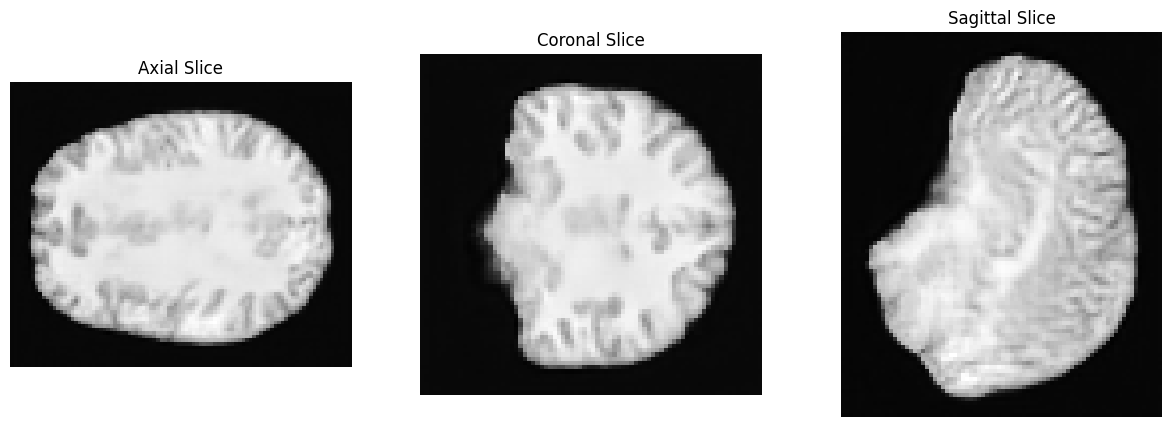

100%|██████████| 1000/1000 [00:18<00:00, 54.37it/s]


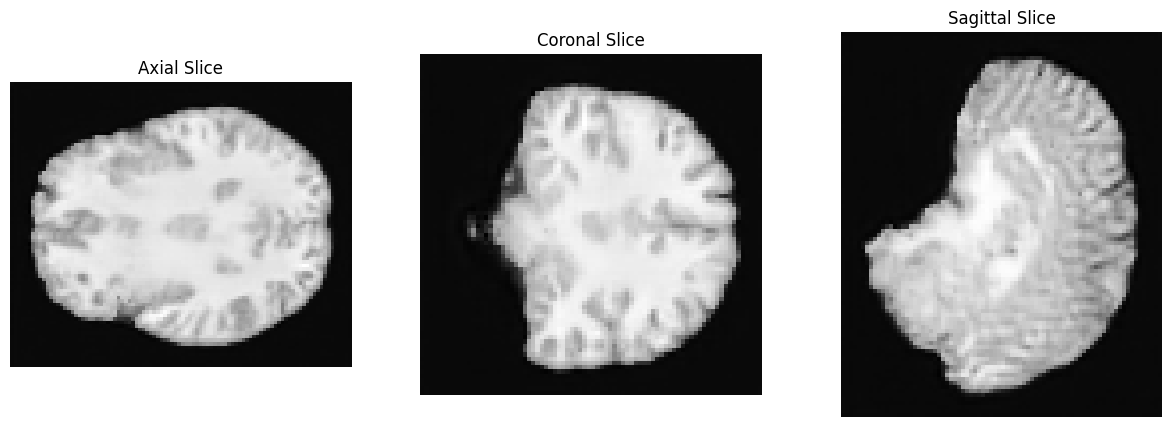

100%|██████████| 1000/1000 [00:18<00:00, 54.07it/s]


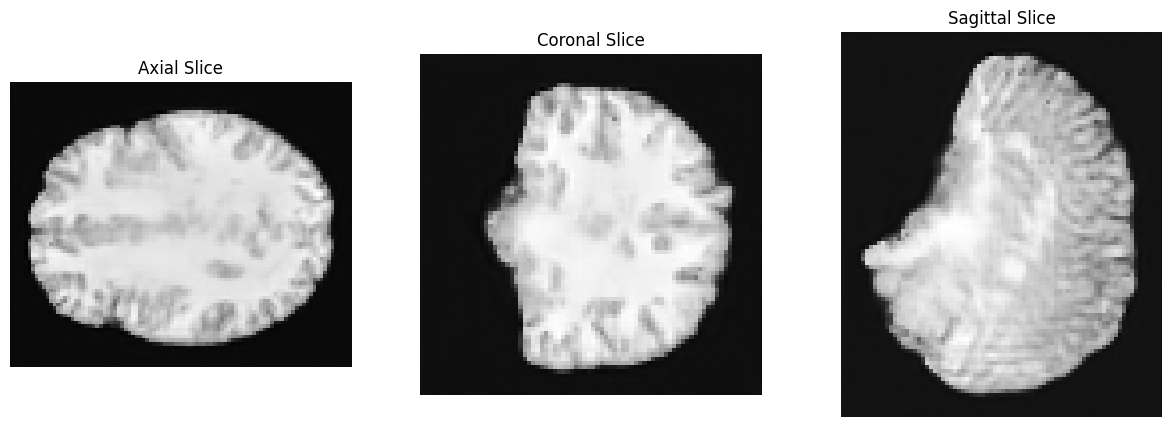

100%|██████████| 1000/1000 [00:18<00:00, 54.27it/s]


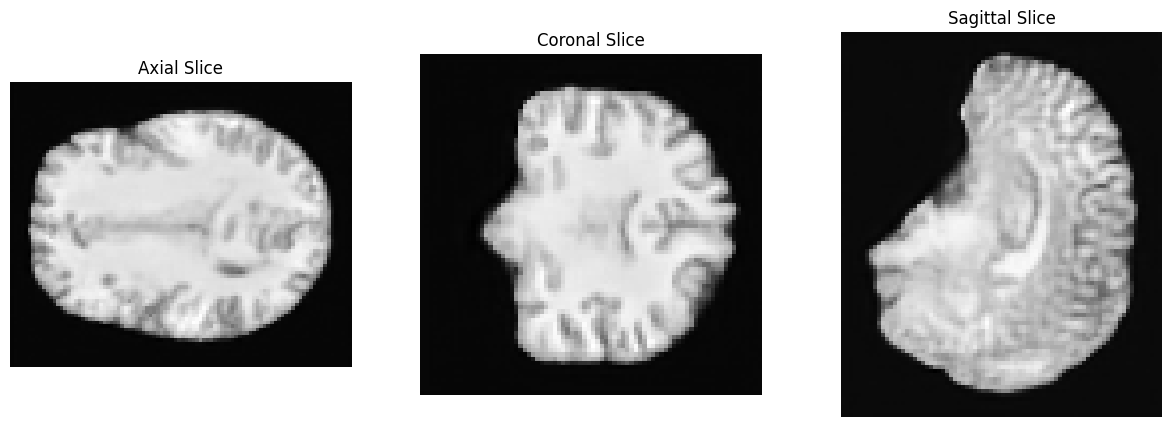

100%|██████████| 1000/1000 [00:18<00:00, 53.96it/s]


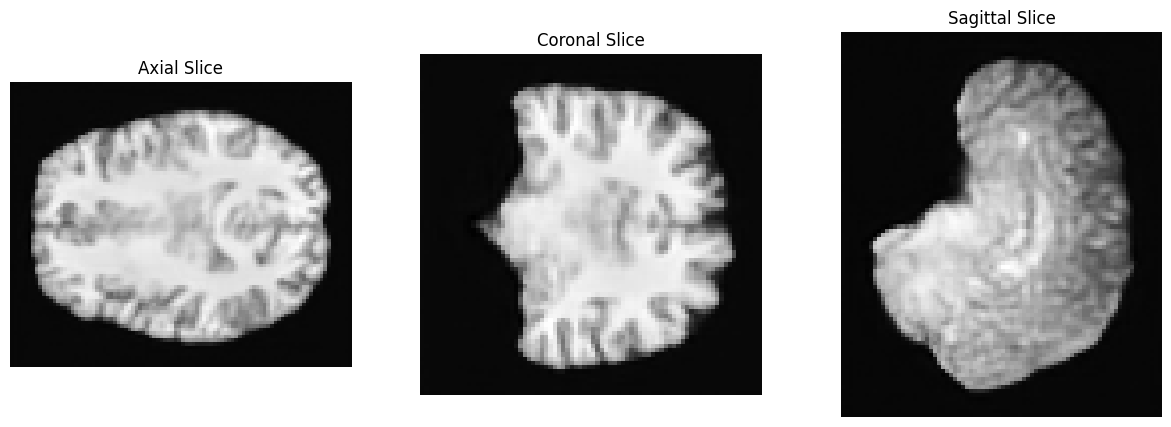

100%|██████████| 1000/1000 [00:18<00:00, 54.04it/s]


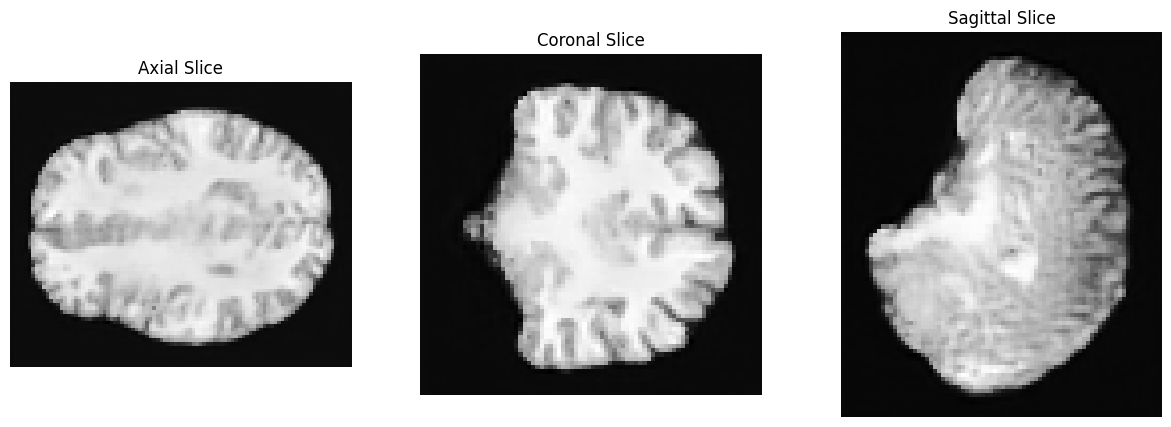

100%|██████████| 1000/1000 [00:20<00:00, 48.44it/s]


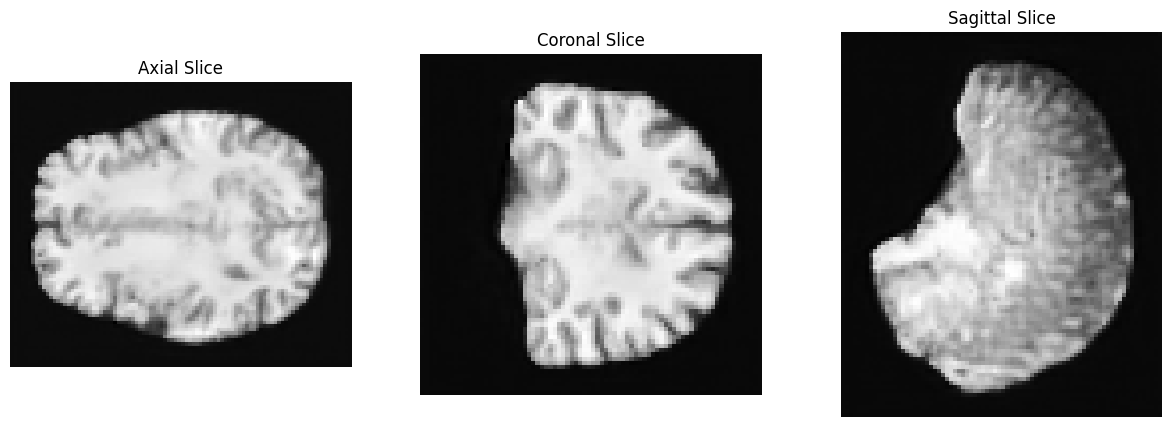

100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


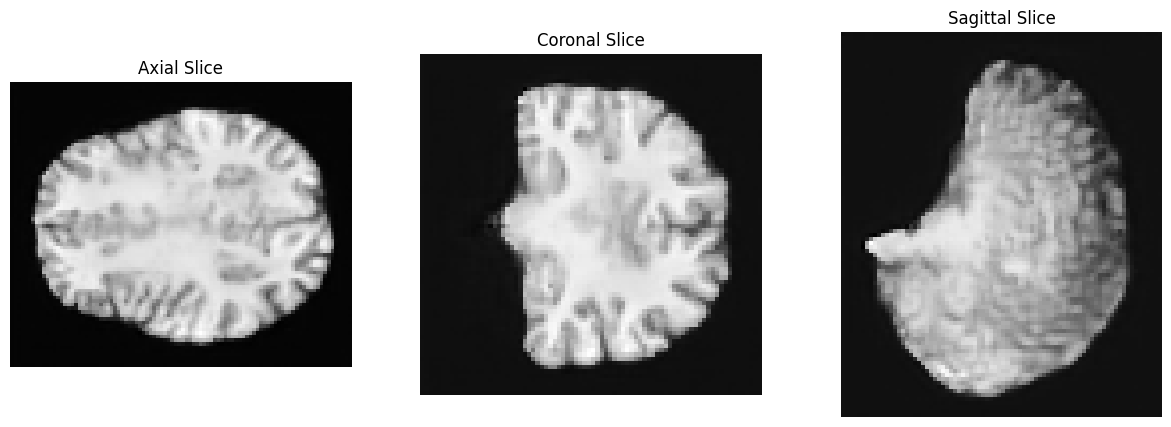

100%|██████████| 1000/1000 [00:21<00:00, 47.50it/s]


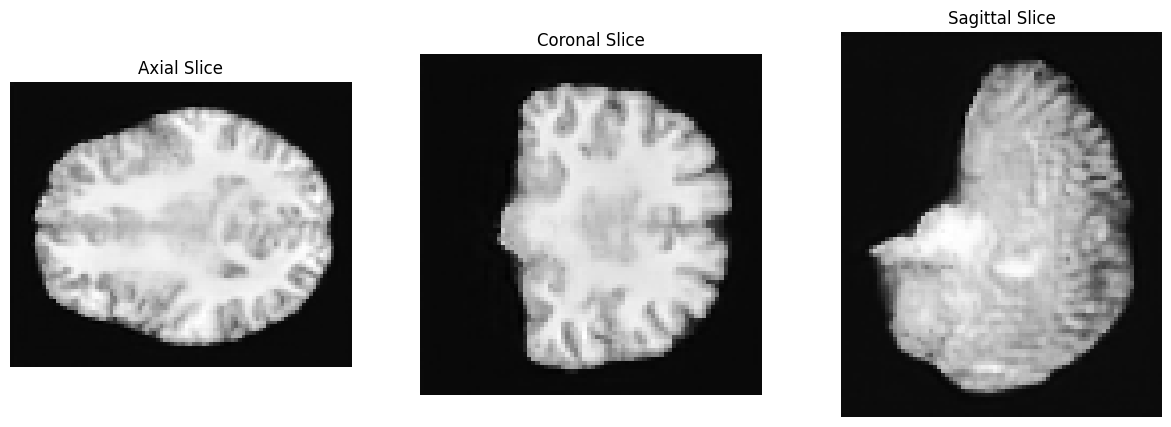

100%|██████████| 1000/1000 [00:21<00:00, 47.09it/s]


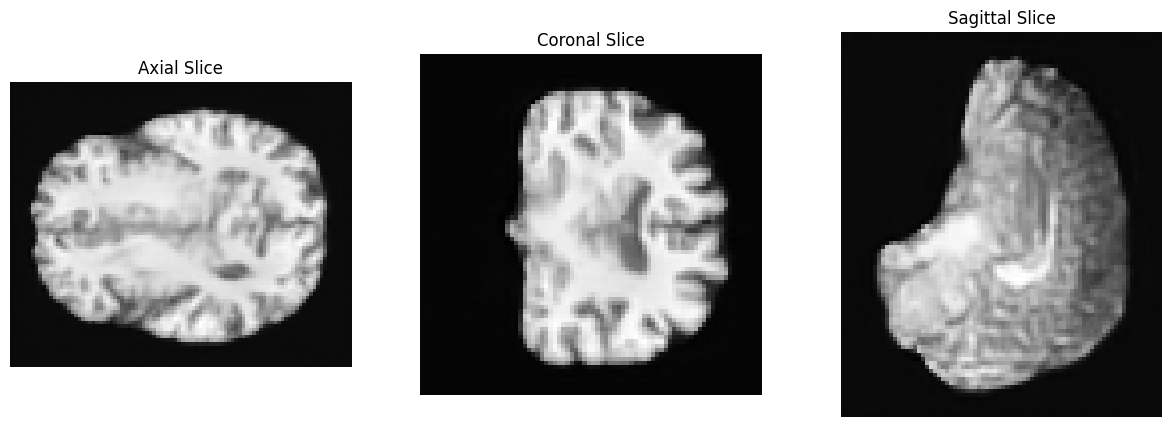

In [47]:
autoencoder.eval()
unet.eval()
num_sample = 10

for i in range(num_sample):
    noise = torch.randn(1, *z.size()[1:]).to(device)
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)
    synthetic_images = inferer.sample(
        input_noise=noise, autoencoder_model=autoencoder, diffusion_model=unet, scheduler=scheduler
    )

    # Assuming synthetic_images is a batch of images, we select the first image
    img = synthetic_images[0, 0].detach().cpu().numpy()  # Take the first image from the batch

    # Set up a figure with 3 subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    for ax in axs:
        ax.axis("off")

    # Plot axial slice
    axs[0].imshow(img[..., img.shape[2] // 2], cmap="gray")
    axs[0].set_title("Axial Slice")

    # Plot coronal slice
    axs[1].imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
    axs[1].set_title("Coronal Slice")

    # Plot sagittal slice
    axs[2].imshow(img[img.shape[0] // 2, ...], cmap="gray")
    axs[2].set_title("Sagittal Slice")

    plt.show()